# Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import itertools

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# auxiliar functions

In [2]:
def walkforward(
    trend_type,
    seasonal_type,
    damped_trend,
    init_method,
    use_boxcox,
    debug=False):

  # store errors
  errors = []
  seen_last = False
  steps_completed = 0

  for end_of_train in range(Ntest, len(df) - h + 1):
    # We don't have to manually "add" the data to our dataset
    # Just index it at the right points - this is a "view" not a "copy"
    # So it doesn't take up any extra space or computation
    train = df.iloc[:end_of_train]
    test = df.iloc[end_of_train:end_of_train + h]

    if test.index[-1] == df.index[-1]:# this is to ensure we have reacht to the end of the data
      seen_last = True
    
    steps_completed += 1

    hw = ExponentialSmoothing(
        train['sales'],
        initialization_method=init_method,
        trend=trend_type,
        damped_trend=damped_trend,
        seasonal=seasonal_type,
        seasonal_periods=12,
        use_boxcox=use_boxcox)
    res_hw = hw.fit()
    
    # compute error for the forecast horizon
    fcast = res_hw.forecast(h)
    ## cuando falla aparecen nulos el mean square error va a dar error 
    if fcast.isnull().values.any():
        return float('inf')
    error = mean_squared_error(test['sales'], fcast)
    errors.append(error)
  if debug:
    print("seen_last:", seen_last)
    print("steps completed:", steps_completed)

  return np.mean(errors)

# Main

In [5]:
df = pd.read_csv('../../datasets/sp500sub.csv', index_col='Date', parse_dates=True)


In [6]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2010-01-04,9.22,9.51,9.17,9.50,9.50,1865400.0,INCY
2010-01-05,9.51,10.29,9.45,10.27,10.27,7608900.0,INCY
2010-01-06,10.38,11.09,10.35,11.00,11.00,8046700.0,INCY
2010-01-07,11.00,11.06,10.62,10.82,10.82,3680300.0,INCY
2010-01-08,10.82,11.00,10.75,10.94,10.94,1529300.0,INCY


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225077 entries, 2010-01-04 to 2018-12-28
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Open       225070 non-null  float64
 1   High       225070 non-null  float64
 2   Low        225070 non-null  float64
 3   Close      225070 non-null  float64
 4   Adj Close  225070 non-null  float64
 5   Volume     225070 non-null  float64
 6   Name       225077 non-null  object 
dtypes: float64(6), object(1)
memory usage: 13.7+ MB


In [8]:
df.isna().sum()

Open         7
High         7
Low          7
Close        7
Adj Close    7
Volume       7
Name         0
dtype: int64

In [9]:
#solo tomammos los valores de cierre de la accion de google
goog = df[df['Name'] == 'GOOG'][['Close']].copy()

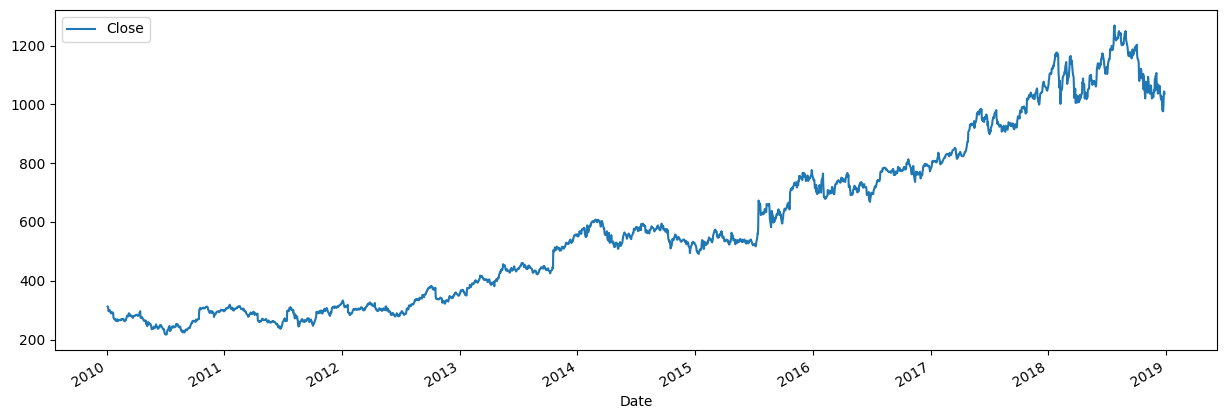

In [10]:
goog.plot(figsize=(15, 5));

In [11]:
goog['LogClose'] = np.log(goog['Close'])

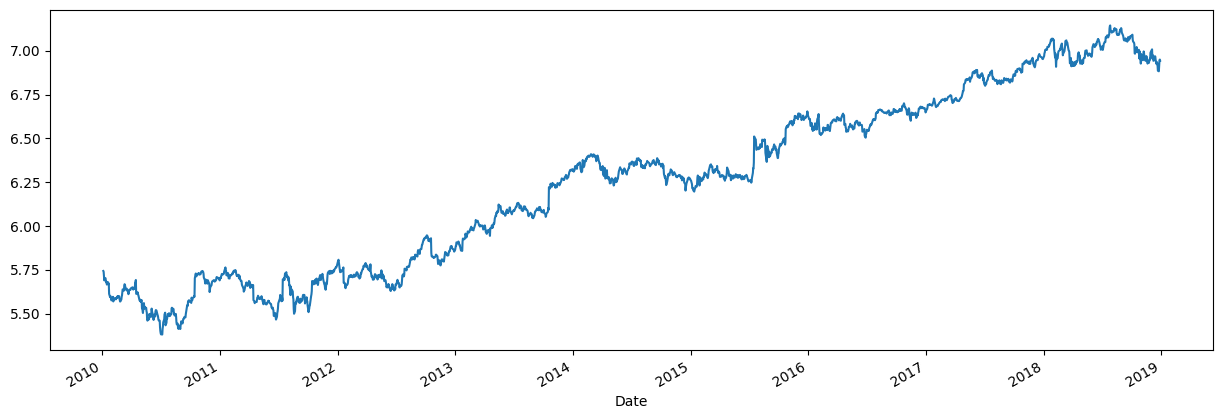

In [12]:
goog['LogClose'].plot(figsize=(15, 5));

In [15]:
(goog.index)

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2018-12-14', '2018-12-17', '2018-12-18', '2018-12-19',
               '2018-12-20', '2018-12-21', '2018-12-24', '2018-12-26',
               '2018-12-27', '2018-12-28'],
              dtype='datetime64[ns]', name='Date', length=2263, freq=None)

In [16]:
Ntest = 30
train = goog.iloc[:-Ntest]
test = goog.iloc[-Ntest:]

In [21]:
# boolean series to index df rows
train_idx = goog.index <= train.index[-1]
test_idx = goog.index > train.index[-1]

In [22]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [23]:
hw = ExponentialSmoothing(
    train['LogClose'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal=None)
res_hw = hw.fit()

C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [24]:
goog.loc[train_idx, 'HoltWintersTrain'] = res_hw.fittedvalues

In [25]:
goog.loc[test_idx, 'HoltWintersTest'] = res_hw.forecast(Ntest).to_numpy()

C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


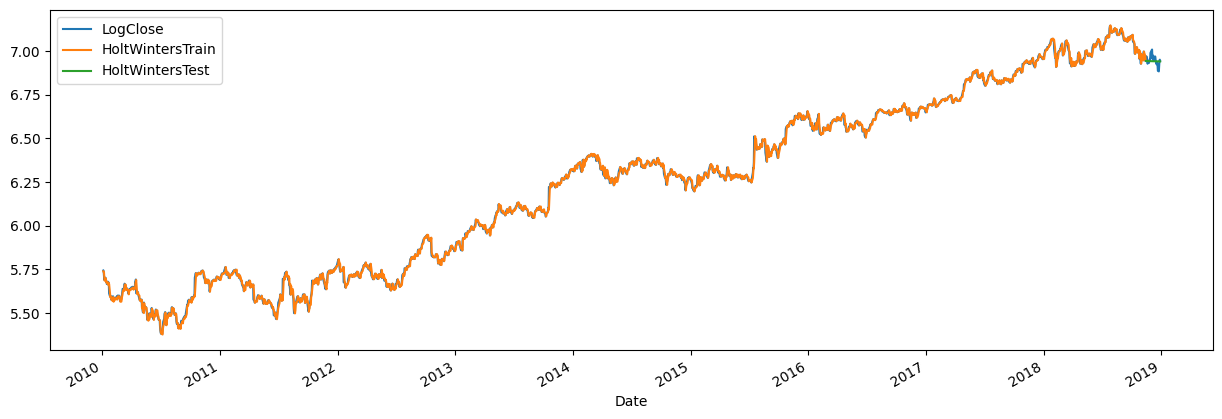

In [26]:
goog[['LogClose', 'HoltWintersTrain', 'HoltWintersTest']].plot(figsize=(15, 5));

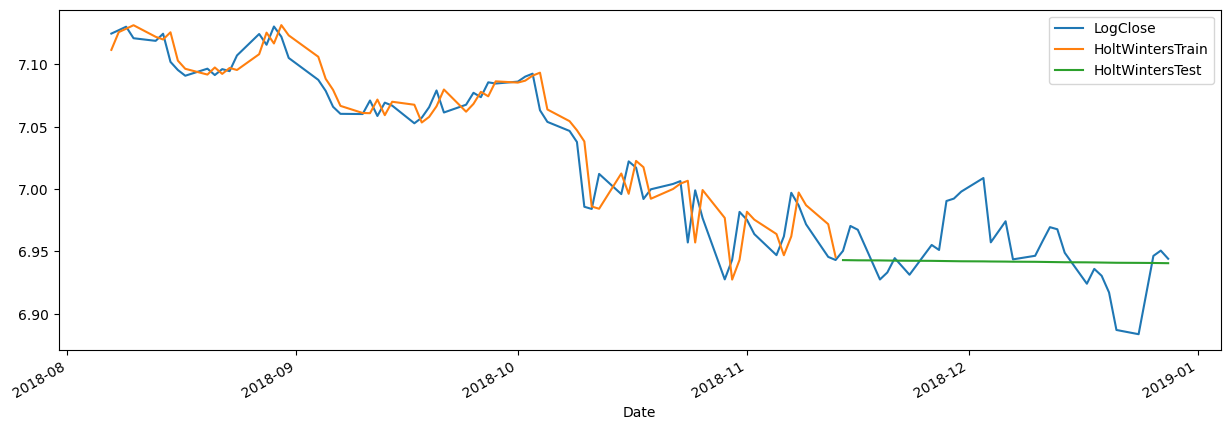

In [27]:
cols = ['LogClose', 'HoltWintersTrain', 'HoltWintersTest']
goog.iloc[-100:][cols].plot(figsize=(15, 5));

In [28]:
goog.loc[test_idx, 'Naive'] = train.iloc[-1]['LogClose']

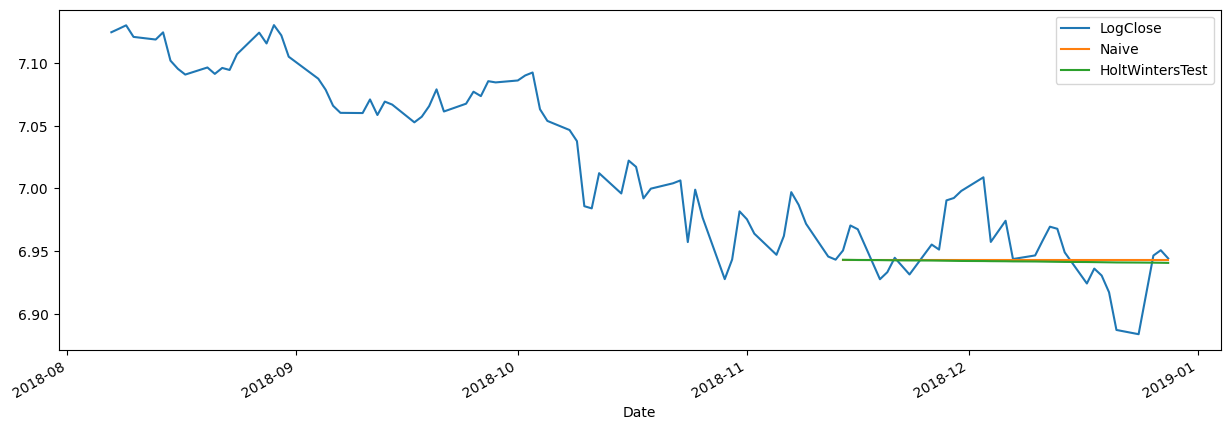

In [29]:
goog.iloc[-100:][['LogClose', 'Naive', 'HoltWintersTest']].plot(figsize=(15, 5));

In [30]:
r2_score(goog.loc[test_idx, 'LogClose'], goog.loc[test_idx, 'Naive'])

-0.06454209862026317

In [31]:
r2_score(goog.loc[test_idx, 'LogClose'], goog.loc[test_idx, 'HoltWintersTest'])

-0.07114166245205311